In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.5/821.5 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 47.9 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [ ]:
'''
Bunch of Hyper parameters (Which you might have to tune later)
'''
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-5             # learning rate
UPDATE_EVERY = 20       # how often to update the network (When Q target is present)

env = gym.make('Acrobot-v1')
state = env.reset()
print(state)

[ 0.9967351   0.08074135  0.9990419  -0.04376357 -0.00476333 -0.01088484]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
class QNetwork1(nn.Module):

  def __init__(self, state_size, action_size, hl_size):
    super(QNetwork1,self).__init__()
    self.input_layer = nn.Linear(state_size,hl_size)
    self.value_layer = nn.Linear(hl_size,1)
    self.advantage_layer = nn.Linear(hl_size,action_size)

  def forward(self,state):
    x = F.relu(self.input_layer(state))
    value = self.value_layer(x)
    advantage = self.advantage_layer(x)
    return value , advantage


network = QNetwork1(6,3,2)
print(network.forward(torch.tensor([[1,1,1,1,1,4],[1,2,3,4,5,4]],dtype=torch.float32)))

(tensor([[2.3368],
        [4.0219]], grad_fn=<AddmmBackward0>), tensor([[-0.7187,  1.8437,  0.8174],
        [ 0.7066,  3.5038,  1.8863]], grad_fn=<AddmmBackward0>))


## Replay Buffer

In [ ]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

#Double DQN

##mean(A)

In [ ]:
class TutorialAgent():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, hl_size = 42).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, hl_size = 42).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.5):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            _,action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return torch.argmax(action_values.to('cpu'),dim=1).item()
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences
        ''' Get max predicted Q values (for next states) from target model'''
        V_targets_next, A_targets_next = self.qnetwork_target(next_states)
        # V_targets_next = V_targets_next.detach().max(1)[0].unsqueeze(1)
        # A_targets_next = A_targets_next.detach().max(1)[0].unsqueeze(1)
        # V_targets_next = V_targets_next.detach().unsqueeze(1)
        # A_targets_next = A_targets_next.detach().unsqueeze(1)
        # print(V_targets_next,A_targets_next)
        Q_targets_next = torch.add(V_targets_next, A_targets_next - A_targets_next.mean(dim=1, keepdim=True)).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # print(Q_targets_next,Q_targets)
        # print(Q_targets_next.shape,Q_targets.shape)
        ''' Get expected Q values from local model '''
        V_targets, A_targets = self.qnetwork_local(states)
        # print(V_targets,A_targets)
        # V_targets = V_targets.detach().unsqueeze(1)
        # A_targets = A_targets.detach().unsqueeze(1)
        # print(states)
        # print(V_targets,A_targets)
        Q_expected = torch.add(V_targets, A_targets - A_targets.mean(dim=1, keepdim=True)).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()
        # if self.t_step == 0:
        #   print("Loss:- ",loss.item())
        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()




In [ ]:
''' Defining DQN Algorithm '''

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n


def dqn(n_episodes=5000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995,print_reward = False):

    scores_window = deque(maxlen=100)
    ''' last 100 scores for checking if the avg is more than 195 '''

    eps = eps_start
    ''' initialize epsilon '''
    total_reward = []
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)
        total_reward.append(score)
        eps = max(eps_end, eps_decay*eps)
        ''' decrease epsilon '''

        # print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, score), end="")
        if i_episode % 10 == 0 and print_reward == True:
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=-102.0:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
           break
    return total_reward

''' Trial run to check if algorithm runs and saves the data '''

begin_time = datetime.datetime.now()

agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)
dqn(print_reward = True)

time_taken = datetime.datetime.now() - begin_time

print(time_taken)

Episode 10	Average Score: -500.00
Episode 20	Average Score: -500.00
Episode 30	Average Score: -495.07
Episode 40	Average Score: -469.82
Episode 50	Average Score: -441.98
Episode 60	Average Score: -418.27
Episode 70	Average Score: -397.74
Episode 80	Average Score: -376.71
Episode 90	Average Score: -359.28
Episode 100	Average Score: -342.45
Episode 110	Average Score: -309.19
Episode 120	Average Score: -276.77
Episode 130	Average Score: -244.40
Episode 140	Average Score: -219.50
Episode 150	Average Score: -200.79
Episode 160	Average Score: -184.18
Episode 170	Average Score: -173.54
Episode 180	Average Score: -164.01
Episode 190	Average Score: -155.90
Episode 200	Average Score: -148.64
Episode 210	Average Score: -145.28
Episode 220	Average Score: -140.50
Episode 230	Average Score: -138.62
Episode 240	Average Score: -136.62
Episode 250	Average Score: -134.08
Episode 260	Average Score: -132.21
Episode 270	Average Score: -128.15
Episode 280	Average Score: -125.55
Episode 290	Average Score: -1

In [ ]:
torch.save(agent.qnetwork_local,'model_acrobot.pth')

In [ ]:
N = 5
reward_avg = []
for i in range(5):
  agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)
  reward_avg.append(dqn())
  print(f'Completed {i+1} iterations')


Environment solved in 1338 episodes!	Average Score: -101.79
Completed 1 iterations

Environment solved in 425 episodes!	Average Score: -101.65
Completed 2 iterations

Environment solved in 443 episodes!	Average Score: -101.93
Completed 3 iterations

Environment solved in 2052 episodes!	Average Score: -101.72
Completed 4 iterations

Environment solved in 416 episodes!	Average Score: -101.74
Completed 5 iterations


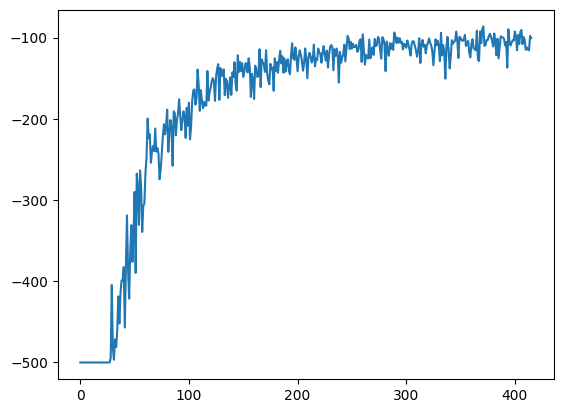

In [ ]:
# reward_avg = np.array(reward_avg)
min_size = min([len(i) for i in reward_avg ])
avg_reward = np.mean(np.array([i[:min_size] for i in reward_avg]),axis = 0)
plt.plot(np.arange(len(avg_reward)),avg_reward)
plt.show()

In [ ]:
reward_save = [i[:min_size] for i in reward_avg]
np.save("reward_Acrobot.npy", reward_save)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##max(A)

In [ ]:
class TutorialAgent():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.lr = LR
        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, hl_size = 42).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, hl_size = 42).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=self.lr)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.5):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            _,action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return torch.argmax(action_values,dim=1).item()
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences
        ''' Get max predicted Q values (for next states) from target model'''
        V_targets_next, A_targets_next = self.qnetwork_target(next_states)
        # V_targets_next = V_targets_next.detach().max(1)[0].unsqueeze(1)
        # A_targets_next = A_targets_next.detach().max(1)[0].unsqueeze(1)
        # V_targets_next = V_targets_next.detach().unsqueeze(1)
        # A_targets_next = A_targets_next.detach().unsqueeze(1)
        Q_targets_next = torch.add(V_targets_next, A_targets_next - torch.max(A_targets_next, dim=1).values.unsqueeze(1)).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # print(Q_targets_next,Q_targets)
        # print(Q_targets_next.shape,Q_targets.shape)
        ''' Get expected Q values from local model '''
        V_targets, A_targets = self.qnetwork_local(states)
        # print(V_targets,A_targets)
        # V_targets = V_targets.detach().unsqueeze(1)
        # A_targets = A_targets.detach().unsqueeze(1)
        # print(states)
        # print(V_targets,A_targets)
        Q_expected = torch.add(V_targets, A_targets - torch.max(A_targets, dim=1).values.unsqueeze(1)).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()
        # if self.t_step == 0:
        #   print("Loss:- ",loss.item())
        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()




In [ ]:
''' Defining DQN Algorithm '''

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n


def dqn(n_episodes=10000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995,print_reward = False):

    scores_window = deque(maxlen=100)
    ''' last 100 scores for checking if the avg is more than 195 '''
    total_reward = []
    eps = eps_start
    ''' initialize epsilon '''

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        total_reward.append(score)
        scores_window.append(score)

        eps = max(eps_end, eps_decay*eps)
        ''' decrease epsilon '''

        # print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, score), end="")

        if i_episode % 10 == 0 and print_reward == True:
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=-102:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
           break
    return total_reward

''' Trial run to check if algorithm runs and saves the data '''

begin_time = datetime.datetime.now()

agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)
dqn(print_reward = True)

time_taken = datetime.datetime.now() - begin_time

print(time_taken)

Episode 10	Average Score: -500.00
Episode 20	Average Score: -500.00
Episode 30	Average Score: -496.37
Episode 40	Average Score: -497.27
Episode 50	Average Score: -484.56
Episode 60	Average Score: -465.50
Episode 70	Average Score: -448.41
Episode 80	Average Score: -422.95
Episode 90	Average Score: -401.12
Episode 100	Average Score: -380.71
Episode 110	Average Score: -354.02
Episode 120	Average Score: -322.64
Episode 130	Average Score: -291.84
Episode 140	Average Score: -261.75
Episode 150	Average Score: -234.43
Episode 160	Average Score: -221.18
Episode 170	Average Score: -202.31
Episode 180	Average Score: -191.87
Episode 190	Average Score: -184.31
Episode 200	Average Score: -180.62
Episode 210	Average Score: -172.27
Episode 220	Average Score: -166.46
Episode 230	Average Score: -167.57
Episode 240	Average Score: -162.07
Episode 250	Average Score: -162.77
Episode 260	Average Score: -152.77
Episode 270	Average Score: -150.88
Episode 280	Average Score: -151.32
Episode 290	Average Score: -1

In [ ]:
torch.save(agent.qnetwork_local,'model_max.pth')

In [ ]:
N = 5
reward_max = []
for i in range(5):
  agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)
  reward_max.append(dqn())
  print(f'Completed {i+1} iterations')


Environment solved in 1649 episodes!	Average Score: -100.81
Completed 1 iterations

Environment solved in 3619 episodes!	Average Score: -100.82
Completed 2 iterations

Environment solved in 2332 episodes!	Average Score: -100.99
Completed 3 iterations

Environment solved in 1628 episodes!	Average Score: -101.45
Completed 4 iterations

Environment solved in 1154 episodes!	Average Score: -100.16
Completed 5 iterations


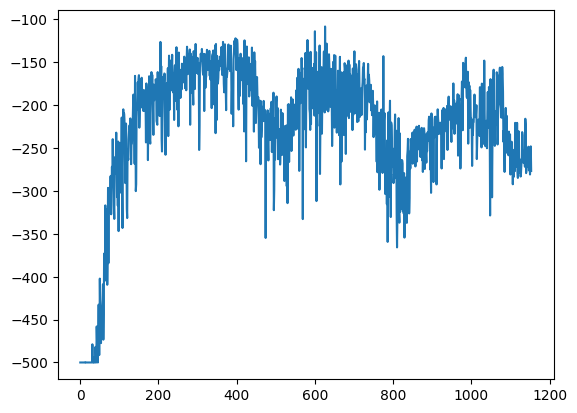

In [ ]:
# reward_max = np.array(reward_max)
min_size = min([len(i) for i in reward_max ])
max_reward = np.mean(np.array([i[:min_size] for i in reward_max]),axis = 0)
plt.plot(np.arange(len(max_reward)),max_reward)
plt.show()

In [ ]:
reward_save = [i[:min_size] for i in reward_max]
np.save("reward_Acrobot_max.npy", reward_save)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


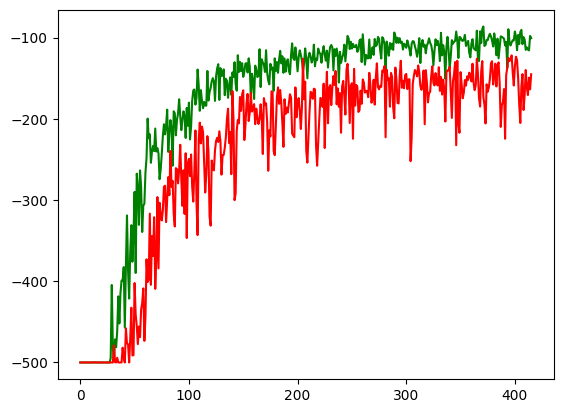

In [ ]:
avg_reward = np.load('reward_Acrobot.npy')
max_reward = np.load('reward_Acrobot_max.npy')
episodes = min(len(avg_reward),len(max_reward))
plt.plot(np.arange(episodes),avg_reward[:episodes],c='g', label='A - mean(A)')
plt.plot(np.arange(episodes),max_reward[:episodes],c='r', label='A - max(A)')

#DQN

##mean(A)

In [ ]:
class TutorialAgent():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, hl_size = 42).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)


    def act(self, state, eps=0.5):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            _,action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return torch.argmax(action_values.to('cpu'),dim=1).item()
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences
        ''' Get max predicted Q values (for next states) from target model'''
        V_targets_next, A_targets_next = self.qnetwork_local(next_states)
        # V_targets_next = V_targets_next.detach().max(1)[0].unsqueeze(1)
        # A_targets_next = A_targets_next.detach().max(1)[0].unsqueeze(1)
        # V_targets_next = V_targets_next.detach().unsqueeze(1)
        # A_targets_next = A_targets_next.detach().unsqueeze(1)
        # print(V_targets_next,A_targets_next)
        Q_targets_next = torch.add(V_targets_next, A_targets_next - A_targets_next.mean(dim=1, keepdim=True)).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # print(Q_targets_next,Q_targets)
        # print(Q_targets_next.shape,Q_targets.shape)
        ''' Get expected Q values from local model '''
        V_targets, A_targets = self.qnetwork_local(states)
        # print(V_targets,A_targets)
        # V_targets = V_targets.detach().unsqueeze(1)
        # A_targets = A_targets.detach().unsqueeze(1)
        # print(states)
        # print(V_targets,A_targets)
        Q_expected = torch.add(V_targets, A_targets - A_targets.mean(dim=1, keepdim=True)).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()
        # if self.t_step == 0:
        #   print("Loss:- ",loss.item())
        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()




In [ ]:
''' Defining DQN Algorithm '''

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n


def dqn(n_episodes=5000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995,print_reward = False):

    scores_window = deque(maxlen=100)
    ''' last 100 scores for checking if the avg is more than 195 '''

    eps = eps_start
    ''' initialize epsilon '''
    total_reward = []
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)
        total_reward.append(score)
        eps = max(eps_end, eps_decay*eps)
        ''' decrease epsilon '''

        # print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, score), end="")
        if i_episode % 10 == 0 and print_reward == True:
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=-102.0:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
           break
    return total_reward

''' Trial run to check if algorithm runs and saves the data '''

begin_time = datetime.datetime.now()

agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)
dqn(print_reward = True)

time_taken = datetime.datetime.now() - begin_time

print(time_taken)

Episode 10	Average Score: -500.00
Episode 20	Average Score: -500.00
Episode 30	Average Score: -495.53
Episode 40	Average Score: -480.45
Episode 50	Average Score: -447.18
Episode 60	Average Score: -427.08
Episode 70	Average Score: -398.71
Episode 80	Average Score: -378.51
Episode 90	Average Score: -358.29
Episode 100	Average Score: -342.19
Episode 110	Average Score: -311.98
Episode 120	Average Score: -279.23
Episode 130	Average Score: -246.45
Episode 140	Average Score: -219.98
Episode 150	Average Score: -202.15
Episode 160	Average Score: -183.05
Episode 170	Average Score: -174.03
Episode 180	Average Score: -164.87
Episode 190	Average Score: -158.40
Episode 200	Average Score: -151.81
Episode 210	Average Score: -145.50
Episode 220	Average Score: -140.68
Episode 230	Average Score: -137.12
Episode 240	Average Score: -133.04
Episode 250	Average Score: -130.85
Episode 260	Average Score: -127.75
Episode 270	Average Score: -125.05
Episode 280	Average Score: -120.98
Episode 290	Average Score: -1

In [ ]:
torch.save(agent.qnetwork_local,'model_acrobot_mean_DQN.pth')

In [ ]:
N = 5
reward_avg = []
for i in range(5):
  agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)
  reward_avg.append(dqn())
  print(f'Completed {i+1} iterations')


Environment solved in 547 episodes!	Average Score: -101.94
Completed 1 iterations

Environment solved in 1307 episodes!	Average Score: -101.79
Completed 2 iterations

Environment solved in 450 episodes!	Average Score: -101.89
Completed 3 iterations

Environment solved in 528 episodes!	Average Score: -101.47
Completed 4 iterations

Environment solved in 582 episodes!	Average Score: -100.68
Completed 5 iterations


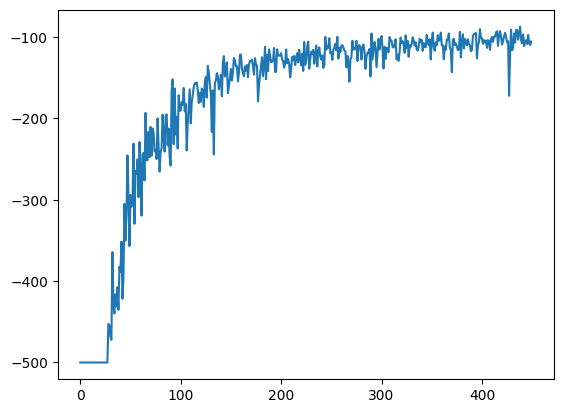

In [ ]:
# reward_avg = np.array(reward_avg)
min_size = min([len(i) for i in reward_avg ])
avg_reward = np.mean(np.array([i[:min_size] for i in reward_avg]),axis = 0)
plt.plot(np.arange(len(avg_reward)),avg_reward)
plt.show()

In [ ]:
reward_save = [i[:min_size] for i in reward_avg]
np.save("reward_Acrobot_mean_DQN.npy", reward_save)

##max(A)

In [ ]:
class TutorialAgent():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.lr = LR
        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, hl_size = 42).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=self.lr)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)


    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)


    def act(self, state, eps=0.5):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            _,action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return torch.argmax(action_values,dim=1).item()
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences
        ''' Get max predicted Q values (for next states) from target model'''
        V_targets_next, A_targets_next = self.qnetwork_local(next_states)
        # V_targets_next = V_targets_next.detach().max(1)[0].unsqueeze(1)
        # A_targets_next = A_targets_next.detach().max(1)[0].unsqueeze(1)
        # V_targets_next = V_targets_next.detach().unsqueeze(1)
        # A_targets_next = A_targets_next.detach().unsqueeze(1)
        Q_targets_next = torch.add(V_targets_next, A_targets_next - torch.max(A_targets_next, dim=1).values.unsqueeze(1)).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # print(Q_targets_next,Q_targets)
        # print(Q_targets_next.shape,Q_targets.shape)
        ''' Get expected Q values from local model '''
        V_targets, A_targets = self.qnetwork_local(states)
        # print(V_targets,A_targets)
        # V_targets = V_targets.detac h().unsqueeze(1)
        # A_targets = A_targets.detach().unsqueeze(1)
        # print(states)
        # print(V_targets,A_targets)
        Q_expected = torch.add(V_targets, A_targets - torch.max(A_targets, dim=1).values.unsqueeze(1)).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()
        # if self.t_step == 0:
        #   print("Loss:- ",loss.item())
        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()




In [ ]:
''' Defining DQN Algorithm '''

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n


def dqn(n_episodes=10000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995,print_reward = False):

    scores_window = deque(maxlen=100)
    ''' last 100 scores for checking if the avg is more than 195 '''
    total_reward = []
    eps = eps_start
    ''' initialize epsilon '''

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        total_reward.append(score)
        scores_window.append(score)

        eps = max(eps_end, eps_decay*eps)
        ''' decrease epsilon '''

        # print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, score), end="")

        if i_episode % 10 == 0 and print_reward == True:
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=-102:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
           break
    return total_reward

''' Trial run to check if algorithm runs and saves the data '''

begin_time = datetime.datetime.now()

agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)
dqn(print_reward = True)

time_taken = datetime.datetime.now() - begin_time

print(time_taken)

Episode 10	Average Score: -500.00
Episode 20	Average Score: -500.00
Episode 30	Average Score: -500.00
Episode 40	Average Score: -500.00
Episode 50	Average Score: -500.00
Episode 60	Average Score: -498.78
Episode 70	Average Score: -491.50
Episode 80	Average Score: -466.38
Episode 90	Average Score: -443.03
Episode 100	Average Score: -421.35
Episode 110	Average Score: -392.83
Episode 120	Average Score: -364.83
Episode 130	Average Score: -335.45
Episode 140	Average Score: -306.36
Episode 150	Average Score: -276.93
Episode 160	Average Score: -245.78
Episode 170	Average Score: -217.65
Episode 180	Average Score: -204.13
Episode 190	Average Score: -199.39
Episode 200	Average Score: -194.13
Episode 210	Average Score: -191.31
Episode 220	Average Score: -185.16
Episode 230	Average Score: -178.70
Episode 240	Average Score: -174.55
Episode 250	Average Score: -170.16
Episode 260	Average Score: -165.90
Episode 270	Average Score: -164.19
Episode 280	Average Score: -162.80
Episode 290	Average Score: -1

In [ ]:
torch.save(agent.qnetwork_local,'model_max_DQN.pth')

In [ ]:
N = 5
reward_max = []
for i in range(5):
  agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)
  reward_max.append(dqn())
  print(f'Completed {i+1} iterations')


Environment solved in 4051 episodes!	Average Score: -100.11
Completed 1 iterations

Environment solved in 4446 episodes!	Average Score: -101.88
Completed 2 iterations

Environment solved in 3644 episodes!	Average Score: -101.95
Completed 3 iterations

Environment solved in 3115 episodes!	Average Score: -101.99
Completed 4 iterations

Environment solved in 3282 episodes!	Average Score: -100.93
Completed 5 iterations


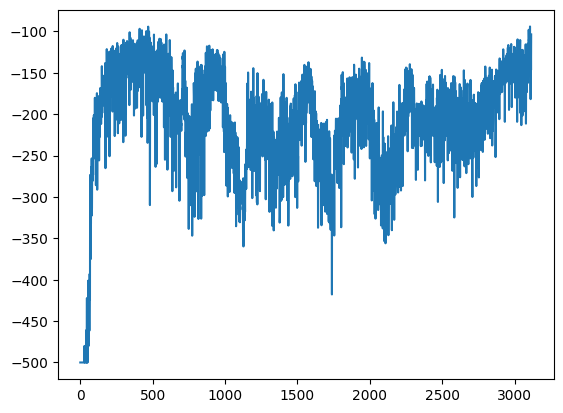

In [ ]:
# reward_max = np.array(reward_max)
min_size = min([len(i) for i in reward_max ])
max_reward = np.mean(np.array([i[:min_size] for i in reward_max]),axis = 0)
plt.plot(np.arange(len(max_reward)),max_reward)
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('Type 2')
plt.legend()

In [ ]:
reward_save = [i[:min_size] for i in reward_max]
np.save("reward_Acrobot_max_DQN.npy", reward_save)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


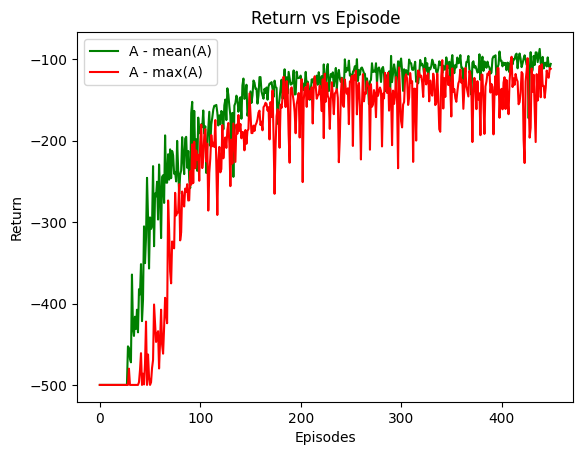

In [3]:
import numpy as np
import matplotlib.pyplot as plt
avg_reward = np.load('reward_Acrobot_mean_DQN.npy')
max_reward = np.load('reward_Acrobot_max_DQN.npy')
min_size = min(min([len(i) for i in max_reward ]),min([len(i) for i in avg_reward ]))
avg_reward = np.mean(np.array([i[:min_size] for i in avg_reward]),axis = 0)
max_reward = np.mean(np.array([i[:min_size] for i in max_reward]),axis = 0)
plt.plot(np.arange(len(avg_reward)),avg_reward,c='g', label='A - mean(A)')
plt.plot(np.arange(len(max_reward)),max_reward,c='r', label='A - max(A)')
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('Return vs Episode')
plt.legend()

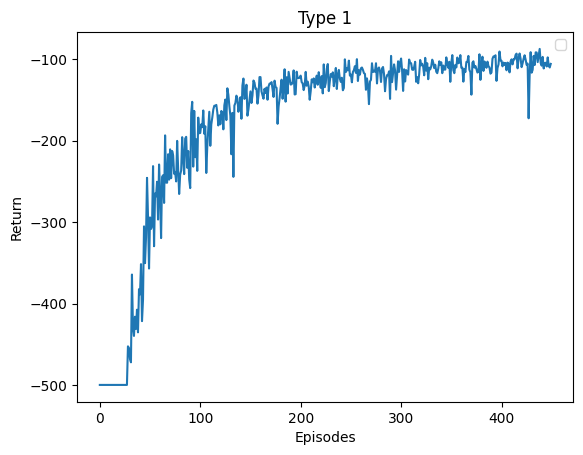

In [6]:
# reward_max = np.array(reward_max)
max_reward = np.load('reward_Acrobot_mean_DQN.npy')
max_reward = np.mean(np.array([i[:min_size] for i in max_reward]),axis = 0)
# min_size = min([len(i) for i in reward_max ])
# max_reward = np.mean(np.array([i[:min_size] for i in reward_max]),axis = 0)
plt.plot(np.arange(len(max_reward)),max_reward)
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('Type 1')
plt.legend()

In [8]:
avg_reward = np.load('reward_Acrobot_mean_DQN.npy')
max_reward = np.load('reward_Acrobot_max_DQN.npy')
min_size = min(min([len(i) for i in max_reward ]),min([len(i) for i in avg_reward ]))
avg_reward = np.mean(np.array([i[:min_size] for i in avg_reward]),axis = 0)
max_reward = np.mean(np.array([i[:min_size] for i in max_reward]),axis = 0)
max_val = max(max(avg_reward),max(max_reward))
print("mean:- ", sum(max_val-avg_reward)/len(avg_reward) )
print("max:- ", sum(max_val-max_reward)/len(max_reward) )

mean:-  85.93466666666677
max:-  125.36488888888891
